In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

MODEL = "gpt-4o-mini"
openai = OpenAI()

system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [2]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

# gr.ChatInterface(fn=chat).launch()

In [3]:
ticket_prices = {"london": "$799",
                 "paris": "$899",
                 "tokyo": "$1400",
                 "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [4]:
booking_confirmations = {
    "london": "The booking to London is confirmed with the ID number 1.",
    "paris": "The booking to Paris is confirmed with the ID number 2.",
    "tokyo": "The booking to Tokyo is confirmed with the ID number 3.",
    "berlin": "The booking to Berlin is confirmed with the ID number 4.",
}

def confirm_booking(destination_city):
    print(f"Tool confirm_booking called for {destination_city}")
    city = destination_city.lower()
    return booking_confirmations.get(city, f"No available bookings for the chosen destination: {destination_city}")

confirm_booking("Berlin")

Tool confirm_booking called for Berlin


'The booking to Berlin is confirmed with the ID number 4.'

In [5]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city" : {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}


booking_confirmation_function = {
    "name": "confirm_booking",
    "description": "Confirm that a booking was made for the given destination city. Call this whenever you need to confirm booking",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city in which the customer wants a booking"
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}


tools = [{"type": "function", "function": price_function},
         {"type": "function", "function": booking_confirmation_function}]

In [7]:
# def chat(message, history):
#     messages = [{"role": "system", "content": system_message}]
#     for human, assistant in history:
#         messages.append({"role": "user", "content": human})
#         messages.append({"role": "assistant", "content": assistant})
#     messages.append({"role": "user", "content": message})
#     response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

#     if response.choices[0].finish_reason == "tool_calls":
#         message = response.choices[0].message
#         # message.tool_calls = [message.tool_calls[0]]
#         response, city = handle_tool_call(message)
#         messages.append(message)
#         messages.append(response)
#         print(f"Messages after appending the message and response: {messages}")
#         response = openai.chat.completions.create(model=MODEL, messages=messages)

#     return response.choices[0].message.content


# def handle_tool_call(message):
#     tool_call = message.tool_calls[0]
#     arguments = json.loads(tool_call.function.arguments)
#     city = arguments.get("destination_city")

#     if tool_call.function.name == "get_ticket_price":
#         key = "price"
#         value = get_ticket_price(city)
#     else:
#         key = "confirmation"
#         value = confirm_booking(city)  
#     print(f"HERE: {message.tool_calls}")
#     response = {
#         "role": "tool",
#         "content": json.dumps({"destination_city": city, key: value}),
#         "tool_call_id": message.tool_calls[0].id
#     }

#     return response, city


# gr.ChatInterface(fn=chat).launch()








def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        # message.tool_calls = [message.tool_calls[0]]
        responses, cities = handle_tool_calls(message)
        messages.append(message)
        for tool_response in responses:
            messages.append(tool_response)
        print(f"Messages after appending the message and response: {messages}")
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content


def handle_tool_calls(message):

    responses = []
    cities = []

    for tool_call in message.tool_calls:
        arguments = json.loads(tool_call.function.arguments)
        city = arguments.get("destination_city")

        if tool_call.function.name == "get_ticket_price":
            key = "price"
            value = get_ticket_price(city)
        else:
            key = "confirmation"
            value = confirm_booking(city)  
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city": city, key: value}),
            "tool_call_id": tool_call.id
        }
        responses.append(response)
        cities.append(city)


    return responses, cities


gr.ChatInterface(fn=chat).launch()

c:\Users\veace\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:279: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Messages after appending the message and response: [{'role': 'system', 'content': "You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. Always be accurate. If you don't know the answer, say so."}, {'role': 'user', 'content': 'price to london'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_wZpvKXQneQZUrYeVwaMbnGGC', function=Function(arguments='{"destination_city":"London"}', name='get_ticket_price'), type='function')]), {'role': 'tool', 'content': '{"destination_city": "London", "price": "$799"}', 'tool_call_id': 'call_wZpvKXQneQZUrYeVwaMbnGGC'}]
Tool get_ticket_price called for Paris
Messages after appending the message and response: [{'role': 'system', 'content': "You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. 

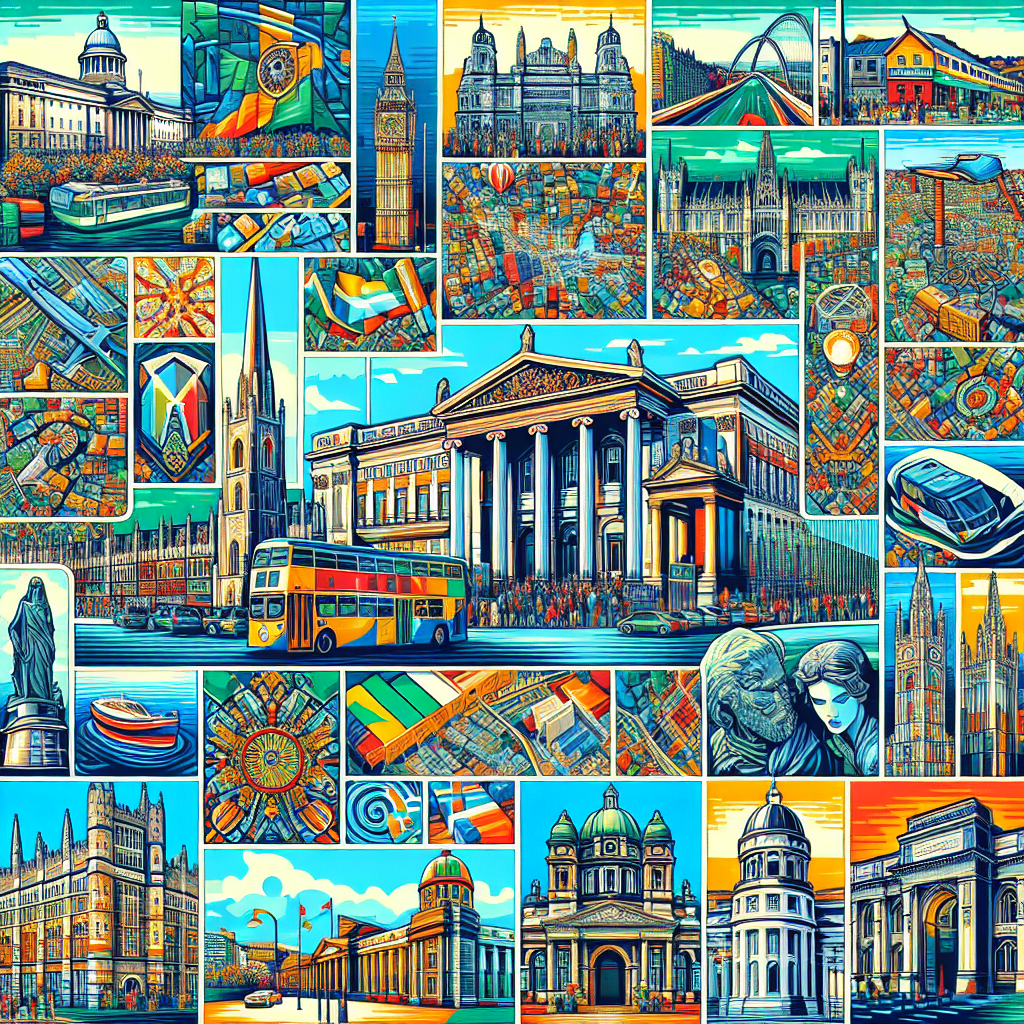

In [21]:
import base64
from io import BytesIO
from PIL import Image

def artist(cities):
    unique_cities = set(cities)
    combined_cities = ", ".join(unique_cities)
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An collage representing a vacation in {combined_cities}, showing tourist spots and everything unique about {combined_cities}, in a vibrant pop-art style. The collage must be divided into {len(combined_cities)} distincy sections, one section for each of the cities. Each city in the collage has to ocupy ots own section without overlapping with other cities' sections",
        size = "1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))


image = artist(["Dublin", "Chisinau"])

display(image)

In [22]:
from pydub import AudioSegment
from pydub.playback import play
import pygame

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )
    audio_stream = BytesIO(response.content)
    pygame.init()
    pygame.mixer.init()
    sound = pygame.mixer.Sound(audio_stream)
    sound.play()
    while pygame.mixer.get_busy():
        pygame.time.delay(100)
    pygame.quit()
 
talker("Well, hi there")

In [23]:
# def chat(message, history):
#     image = None
#     conversation = [{"role": "system", "content": system_message}]
#     for human, assistant in history:
#         conversation.append({"role": "user", "content": human})
#         conversation.append({"role": "assistant", "content": assistant})
#     conversation.append({"role": "user", "content": message})
#     response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)

#     if response.choices[0].finish_reason=="tool_calls":
#         message = tool_call = response.choices[0].message
#         print(f"This is the message: {message}")
#         response, city = handle_tool_calls(message)
#         conversation.append(message)
#         conversation.append(response)
#         image = artist(city)
#         response = openai.chat.completions.create(model=MODEL, messages=conversation)

#     reply = response.choices[0].message.content
#     talker(reply)
#     return reply, image




def chat(message, history):
    image = None
    conversation = [{"role": "system", "content": system_message}]

    for human, assistant in history:
        conversation.append({"role": "user", "content": human})
        conversation.append({"role": "assistant", "content": assistant})
    conversation.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls(message)
        conversation.append(message)
        for tool_response in responses:
            conversation.append(tool_response)
        image = artist(cities)
        response = openai.chat.completions.create(model=MODEL, messages=conversation)

    reply = response.choices[0].message.content
    talker(reply)
    return reply, image

In [24]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)
    with gr.Row():
        msg = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]
    
    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image
    
    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, [chatbot, image_output]
    )

    clear.click(lambda: None, None, chatbot, queue=False)


ui.launch()

c:\Users\veace\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:273: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Tool get_ticket_price called for Paris
Tool confirm_booking called for London
Tool confirm_booking called for Paris
Tool confirm_booking called for London
Tool confirm_booking called for Paris
